In [193]:
# Setup

%load_ext autoreload
%autoreload 2
%aimport

%matplotlib inline 

import matplotlib.pyplot as plt
import torch

from bliss.inference import SDSSFrame
from bliss.datasets import sdss
from bliss.inference import reconstruct_scene_at_coordinates
from case_studies.sdss_galaxies.plots.main import load_models


from astropy.table import Table

import plotly.express as px
import plotly.graph_objects as go

# check GPU is configured correctly
device = torch.device('cuda:0')
!echo $CUDA_VISIBLE_DEVICES

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:

5


In [194]:
# load models
from hydra import compose, initialize
from hydra.utils import instantiate
from bliss.encoder import Encoder

with initialize(config_path="../config"):
    cfg = compose("config", overrides=[])
    

In [195]:
single_prior = instantiate(cfg.datasets.sdss_galaxies.prior)
single_decoder = instantiate(cfg.datasets.sdss_galaxies.decoder)

In [196]:
from bliss.models.galsim_decoder import UniformGalsimGalaxiesPrior
prior = UniformGalsimGalaxiesPrior(single_prior, max_n_sources=5, max_shift=0.5)

In [252]:
# check samples look OK 
sample = prior.sample()
print(sample)

{'n_sources': tensor(5), 'galaxy_params': tensor([[1.7740e+03, 7.4860e-02, 4.0898e+00, 1.3400e-01, 9.9047e-01, 5.8272e-01,
         9.4578e-01],
        [4.2501e+04, 1.9360e-01, 1.8160e+00, 1.2765e-01, 1.0193e+00, 5.5327e-01,
         7.4227e-01],
        [1.5663e+03, 7.0529e-01, 5.1892e+00, 4.2836e-02, 2.1668e+00, 9.0978e-01,
         8.8042e-01],
        [9.1097e+02, 1.2333e-01, 6.0551e+00, 9.6248e-01, 9.0462e+00, 5.9337e-02,
         1.1075e+00],
        [2.0044e+03, 2.4847e-01, 6.5305e-01, 7.8277e-01, 8.4492e-01, 3.8886e-01,
         7.1306e-01]]), 'locs': tensor([[0.5629, 0.9400],
        [0.2560, 0.9320],
        [0.6823, 0.5800],
        [0.1947, 0.9216],
        [0.3184, 0.6219]]), 'galaxy_bools': tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]]), 'star_bools': tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])}


In [253]:
# now load full decoder
from bliss.models.galsim_decoder import GalsimGalaxiesDecoder
slen = 40
bp = 12
decoder = GalsimGalaxiesDecoder(single_decoder, slen, bp)

In [267]:
# turn sample to FullCatalog
from bliss.catalog import FullCatalog
params_dict = {**sample}
params_dict["plocs"] = params_dict["locs"] * slen
params_dict.pop('locs')
params_dict = {k: v.unsqueeze(0) for k, v in params_dict.items()}
full_cat = FullCatalog(slen, slen, params_dict)
print(full_cat['galaxy_bools'].shape)

torch.Size([1, 5, 1])


In [265]:
tile_cat = full_cat.to_tile_params(4, 1)
tile_cat['galaxy_bools'].shape

torch.Size([1, 10, 10, 1, 1])

In [256]:
images, centered, uncentered = decoder(full_cat)

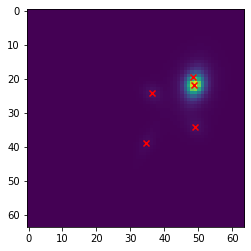

In [257]:
plocs_numpy = full_cat.plocs.numpy()
plt.imshow(images[0, 0].numpy())
plt.scatter(plocs_numpy[0, :, 1] + decoder.bp - 0.5, plocs_numpy[0, :, 0] + decoder.bp - 0.5, marker='x', c='r')

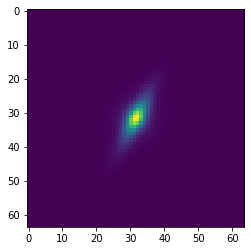

In [258]:
plt.imshow(centered[0, 2, 0].numpy())

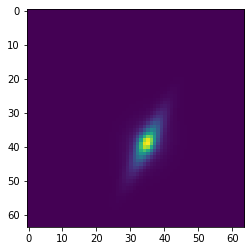

In [259]:
plt.imshow(uncentered[0, 2, 0].numpy())

In [268]:
# now dataset 
from bliss.datasets.galsim_galaxies import GalsimBlends
from bliss.datasets.background import ConstantBackground
background = ConstantBackground((860.,))
ds = GalsimBlends(prior, decoder, background, 4, 1, 0, 1, False, 1 )

In [371]:
batch = ds[0]


{'galaxy_params': tensor([[[1.6287e+05, 5.9703e-01, 3.4993e+00, 9.5937e-01, 1.0086e+00,
          6.0204e-01, 7.8387e+00],
         [7.3846e+02, 5.8839e-01, 1.9646e+00, 2.6679e-01, 2.5681e+00,
          6.0336e-01, 1.6943e+00],
         [7.9172e+03, 2.8914e-01, 1.5801e+00, 7.7812e-01, 1.9608e+00,
          9.2864e-05, 5.4197e-01],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00]]]), 'galaxy_bools': tensor([[[1.],
         [1.],
         [1.],
         [0.],
         [0.]]]), 'star_bools': tensor([[[0.],
         [0.],
         [0.],
         [0.],
         [0.]]]), 'mags': tensor([[[16.9565],
         [22.8153],
         [20.2397],
         [ 0.0000],
         [ 0.0000]]]), 'fluxes': tensor([[[0.],
         [0.],
         [0.],
         [0.],
         [0.]]]), 'log_fluxes': tensor([[[0.],
         [0.],
         [0.],
         [

IndexError: index 1 is out of bounds for dimension 3 with size 1

In [274]:
batch['galaxy_bools'].shape

torch.Size([10, 10, 1, 1])